# WCWH Community Rollout Preparation - BEVO Beacon Design
For the upcoming rollout, we need to ensure proper aspects of the beacon are working correctly.

In [2]:
import warnings
warnings.filterwarnings('ignore')

# CO2 Sensitivity Analysis
Now that the CO2 sensors have calibrated, it is of interest to see how well they report values especially under varied conditions.

In [97]:
import os
import sys
sys.path.append('../')

from src.data import make_dataset
from src.calibration import calibrate

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Beacon Overview - CO2
We want to look at which beacons are actually providing good CO2 data as those should be which ones we target for the test. We have reference data for at least an hour that we can compare the beacons to.

In [98]:
# getting reference data
ref = pd.read_csv("../data/calibration/co2_01262021.csv",usecols=[0,1],names=["timestamp","co2"])
ref["timestamp"] = pd.to_datetime(ref["timestamp"],yearfirst=True)
ref.set_index("timestamp",inplace=True)
ref.index += timedelta(minutes=3)
# getting beacon data
beacon = pd.read_csv("../data/processed/beacon-wcwh_s20.csv",index_col=0,parse_dates=True,infer_datetime_format=True)

The one-hour test was conducted between 9:05 - 10:05 CST and consisted of just one occupant and a 2-minute jumping jacks session 40 minutes into the test.

In [99]:
def get_marker(number):
    """
    Gets a marker style based on the beacon number
    """
    if number < 10:
        m = "s"
    elif number < 20:
        m = "^"
    elif number < 30:
        m = "P"
    elif number <40:
        m = "*"
    else:
        m = "o"

    return m

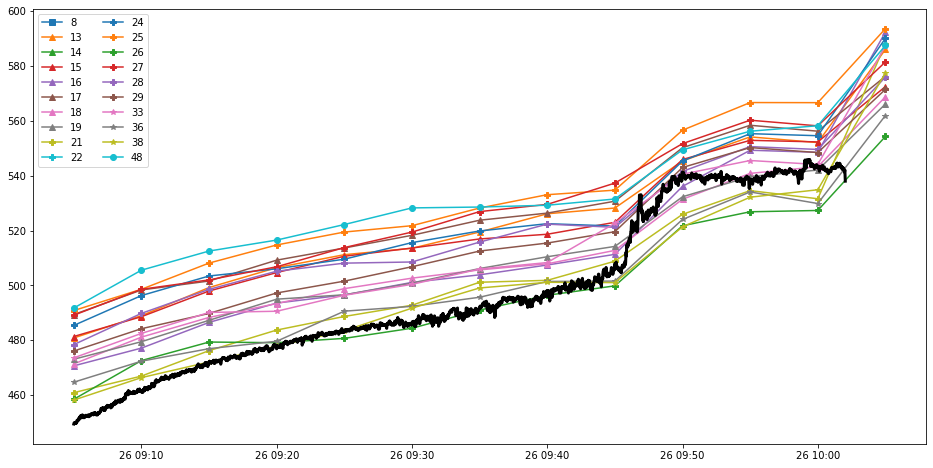

In [100]:
fig, ax = plt.subplots(figsize=(16,8))
for bb in beacon["beacon"].unique():
    if bb not in [1,2,4,5,7,10,12,20,23,31,32,34,37,40,43,44,46]:
        beacon_by_bb = beacon[beacon["beacon"] == bb]
        beacon_by_bb = beacon_by_bb[datetime(2021,1,26,9,5):datetime(2021,1,26,10,5)]
        ax.plot(beacon_by_bb.index,beacon_by_bb["co2"],marker=get_marker(bb),label=bb)
    
ref = ref[datetime(2021,1,26,9,5):datetime(2021,1,26,10,5)]
ax.plot(ref.index,ref["co2"],color="black",linewidth=3)

ax.legend(ncol=2)
plt.show()
plt.close()

Based on the figure above, the beacons we should co-locate with the display beacons are: [16,21,26,36,38]

## Analysis Class
The class below should properly import and run the various experiments for this analysis

In [107]:
class CO2_Sensitivity:
    
    def __init__(self, beacon_list, ref_beacon, start_datetime, end_datetime):
        self.beacons = beacon_list
        
        beacon = pd.read_csv("../data/processed/beacon-wcwh_s20.csv",index_col=0,parse_dates=True,infer_datetime_format=True)
        self.data = beacon[beacon["beacon"].isin(self.beacons)] # experiment data
        #self.data = self.data[start_datetime:end_datetime]
        
        self.ref = beacon[beacon["beacon"] == ref_beacon]
        #self.ref = self.ref[start_datetime:end_datetime]
        
        self.start_datetime = start_datetime
        self.end_datetime = end_datetime
        
    def plot_ts(self):
        """
        Plots time series of data
        """
        fig, ax = plt.subplots(figsize=(16,8))
        for bb in self.beacons:
            data_by_bb = self.data[self.data["beacon"] == bb]
            ax.plot(data_by_bb.index,data_by_bb["co2"],linewidth=2,label=bb)
            
        ax.plot(self.ref.index,self.ref["co2"],color="black",linewidth=3,label="reference")
        ax.set_xlim([self.start_datetime,self.end_datetime])
        ax.legend()
        
        plt.show()
        plt.close()
            

## Analysis
The following cells run through some basic analysis of the experiments noted below:

### Experiment 2
**Description**: Single occupant experiment CO2 injected to center of kitchen in the UTest House <br>
**Start**: datetime(2021,1,26,14) <br>
**End**: datetime(2021,1,27,0) <br>
**Notes**:
- CO2 injected at 14:15
- CO2 cylinder closed at 14:30
- Occupant left around 15:15

In [108]:
co2 = CO2_Sensitivity(beacon_list=[1,2,5,10,12],ref_beacon=4,start_datetime=datetime(2021,1,26,14),end_datetime=datetime(2021,1,27,0))

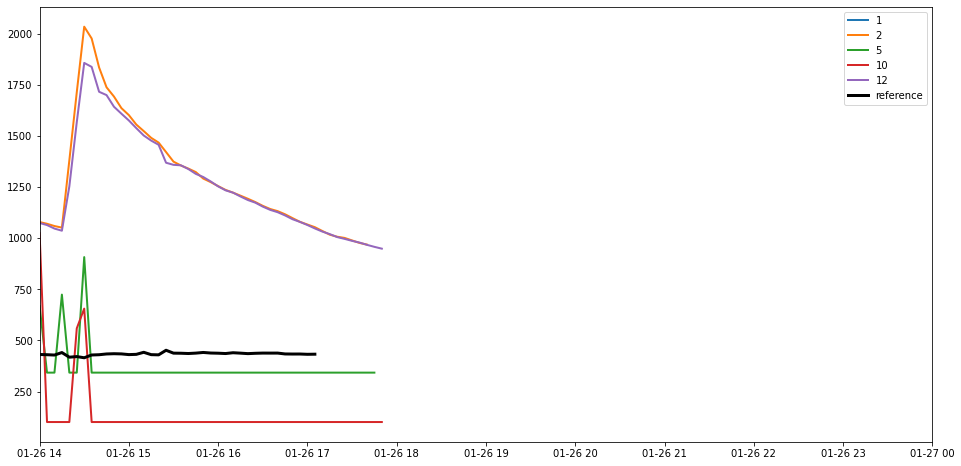

In [109]:
co2.plot_ts()